# layout detection

In [1]:
from surya.detection import batch_text_detection
from surya.layout import batch_layout_detection
from surya.model.detection.segformer import load_model, load_processor
from surya.model.ordering.processor import load_processor as load_order_processor
from surya.model.ordering.model import load_model as load_order_model
from PIL import Image
from surya.settings import settings


def load_det_cached():
    checkpoint = settings.DETECTOR_MODEL_CHECKPOINT
    return load_model(checkpoint=checkpoint), load_processor(checkpoint=checkpoint)


# def load_rec_cached():
#     return load_rec_model(), load_rec_processor()


def load_layout_cached():
    return load_model(checkpoint=settings.LAYOUT_MODEL_CHECKPOINT), load_processor(checkpoint=settings.LAYOUT_MODEL_CHECKPOINT)

def load_order_cached():
    return load_order_model(), load_order_processor()


det_model, det_processor = load_det_cached()
# rec_model, rec_processor = load_rec_cached()
layout_model, layout_processor = load_layout_cached()
order_model, order_processor = load_order_cached()


/home/erwan/anaconda3/envs/scienceinfuse/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded detection model vikp/surya_det2 on device cuda with dtype torch.float16
Loaded detection model vikp/surya_layout2 on device cuda with dtype torch.float16
Loaded reading order model vikp/surya_order on device cuda with dtype torch.float16


In [2]:
import pymupdf as fitz
from pymupdf import Document
def get_image_from_page(doc, page):
    page = doc[page]
    dpi = 72
    zoom = dpi / 72  # 72 is the default DPI
    mat = fitz.Matrix(zoom, zoom)
    pix = page.get_pixmap(matrix=mat)
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    return img

In [18]:
from typing import List, Tuple
from surya.postprocessing.heatmap import draw_polys_on_image
from surya.schema import OCRResult, TextDetectionResult, LayoutResult, OrderResult
from PIL import Image
from surya.ordering import batch_ordering


def texts_detection(images: List[Image.Image], batch_size=10) -> List[TextDetectionResult]:
    preds = batch_text_detection(images, det_model, det_processor, batch_size=batch_size)
    return preds

def layout_detection(images: List[Image.Image], batch_size=10) -> List[LayoutResult]:
    _det_preds = texts_detection(images, batch_size=batch_size)
    preds = batch_layout_detection(images, layout_model, layout_processor, _det_preds, batch_size=batch_size)
    return preds

def order_detection(images: List[Image.Image], batch_size=10) -> List[Tuple[Image.Image, OrderResult]]:
    layout_preds = layout_detection(images, batch_size=batch_size)
    all_bboxes = []
    all_labels = []
    for layout_pred in layout_preds:
        bboxes = [l.bbox for l in layout_pred.bboxes]
        labels = [l.label for l in layout_pred.bboxes]
        all_labels.append(labels)
        all_bboxes.append(bboxes)
    preds = batch_ordering(images, all_bboxes, order_model, order_processor, batch_size=batch_size)
    all_polys = []
    all_positions = []
    for pred in preds:
        polys = [l.polygon for l in pred.bboxes]
        all_polys.append(polys)
        positions = [str(l.position) for l in pred.bboxes]
        all_positions.append(positions)

    order_imgs = []
    for idx, img in enumerate(images):
        order_img = draw_polys_on_image(all_polys[idx], img.copy(), labels=all_positions[idx], label_font_size=20)
        order_imgs.append(order_img)
    return order_imgs, preds, all_labels

def process_pdf_texts(doc: type[Document], batch_size=2):
    # images = [get_image_from_page(doc, page_number) for page_number in range(20)]
    images = [get_image_from_page(doc, page_number) for page_number in range(len(doc))]
    # print(images)
    order_imgs, preds, labels = order_detection(images, batch_size=batch_size)
    return order_imgs, preds, labels


# pdf_path = "./data/UniversScience/revue-decouverte/decouverte_436.pdf"
pdf_path = "./data/UniversScience/dossiers-pédagogiques/astro/2015/2015 - Dinosaures.pdf"
doc = fitz.open(pdf_path)
result_imgs, result_preds, result_labels = process_pdf_texts(doc, batch_size=8)
# max 8 on my laptop, increse on server


Finding reading order: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]


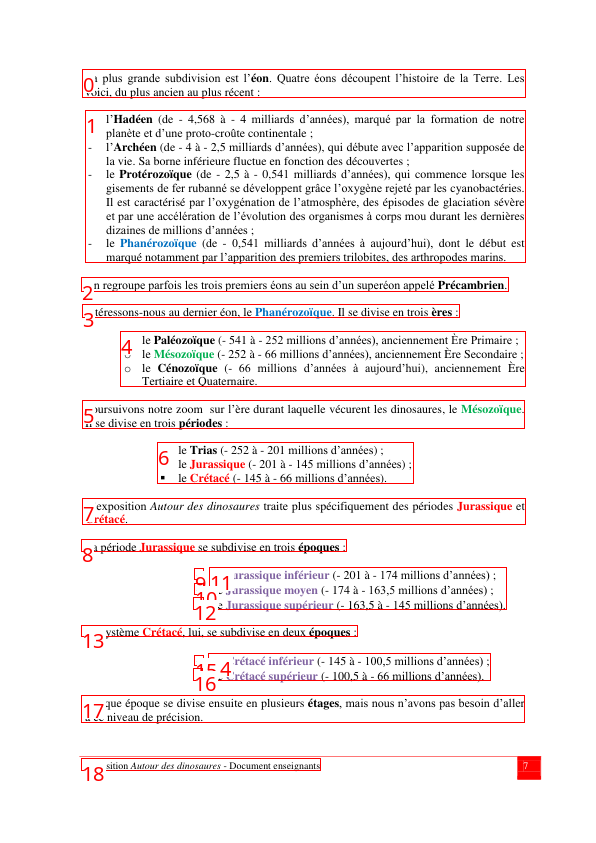

pos      : 0
label    : Text
cur_title: 
cur_subtitle: 
text     : La plus grande subdivision est l’éon. Quatre éons découpent l’histoire de la Terre. Les voici, du plus ancien au plus récent :
len text : 126


pos      : 1
label    : Text
cur_title: 
cur_subtitle: 
text     : -  l’Hadéen (de - 4,568 à - 4 milliards d’années), marqué par la formation de notre planète et d’une proto-croûte continentale ;
-  l’Archéen (de - 4 à - 2,5 milliards d’années), qui débute avec l’apparition supposée de la vie. Sa borne inférieure fluctue en fonction des découvertes ;
-  le Protérozoïque (de - 2,5 à - 0,541 milliards d’années), qui commence lorsque les gisements de fer rubanné se développent grâce l’oxygène rejeté par les cyanobactéries. Il est caractérisé par l’oxygénation de l’atmosphère, des épisodes de glaciation sévère et par une accélération de l’évolution des organismes à corps mou durant les dernières dizaines de millions d’années ;
-  le Phanérozoïque (de - 0,541 milliards d’années à auj

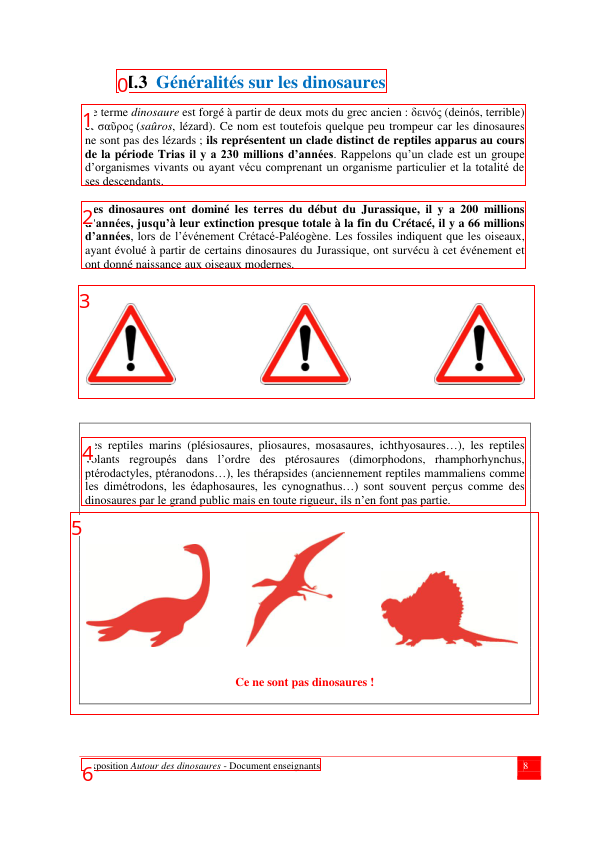

pos      : 1
label    : Text
cur_title: 
cur_subtitle: II.3 Généralités sur les dinosaures
text     : Le terme dinosaure est forgé à partir de deux mots du grec ancien : δεινός (deinόs, terrible) et σαῦρος (saûros, lézard). Ce nom est toutefois quelque peu trompeur car les dinosaures ne sont pas des lézards ; ils représentent un clade distinct de reptiles apparus au cours de la période Trias il y a 230 millions d’années. Rappelons qu’un clade est un groupe d’organismes vivants ou ayant vécu comprenant un organisme particulier et la totalité de ses descendants.
len text : 464


pos      : 2
label    : Text
cur_title: 
cur_subtitle: II.3 Généralités sur les dinosaures
text     : Les dinosaures ont dominé les terres du début du Jurassique, il y a 200 millions d’années, jusqu’à leur extinction presque totale à la fin du Crétacé, il y a 66 millions d’années, lors de l’événement Crétacé-Paléogène. Les fossiles indiquent que les oiseaux, ayant évolué à partir de certains dinosaures du Jurassi

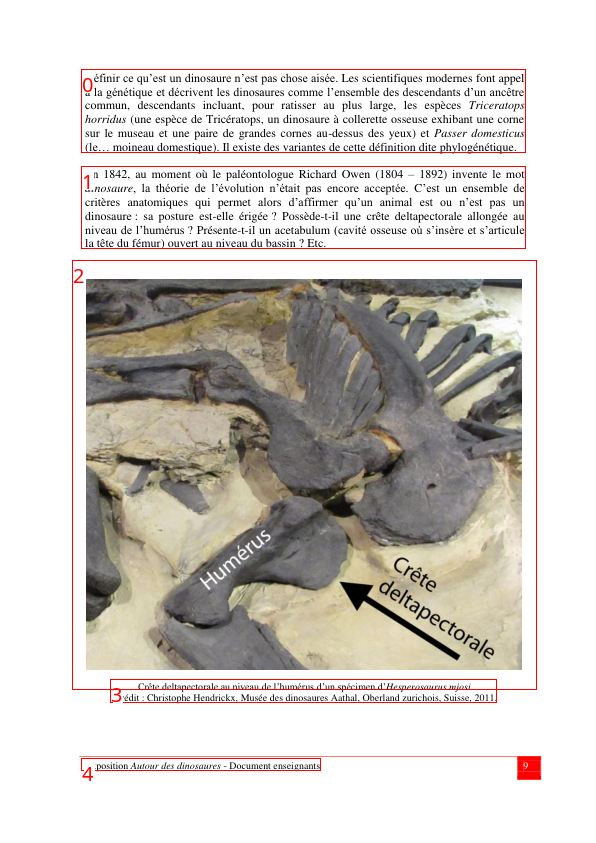

pos      : 0
label    : Text
cur_title: 
cur_subtitle: II.3 Généralités sur les dinosaures
text     : Définir ce qu’est un dinosaure n’est pas chose aisée. Les scientifiques modernes font appel à la génétique et décrivent les dinosaures comme l’ensemble des descendants d’un ancêtre commun, descendants incluant, pour ratisser au plus large, les espèces Triceratops horridus (une espèce de Tricératops, un dinosaure à collerette osseuse exhibant une corne sur le museau et une paire de grandes cornes au-dessus des yeux) et Passer domesticus (le… moineau domestique). Il existe des variantes de cette définition dite phylogénétique.
len text : 530


pos      : 1
label    : Text
cur_title: 
cur_subtitle: II.3 Généralités sur les dinosaures
text     : En 1842, au moment où le paléontologue Richard Owen (1804 – 1892) invente le mot dinosaure, la théorie de l’évolution n’était pas encore acceptée. C’est un ensemble de critères anatomiques qui permet alors d’affirmer qu’un animal est ou n’est pas u

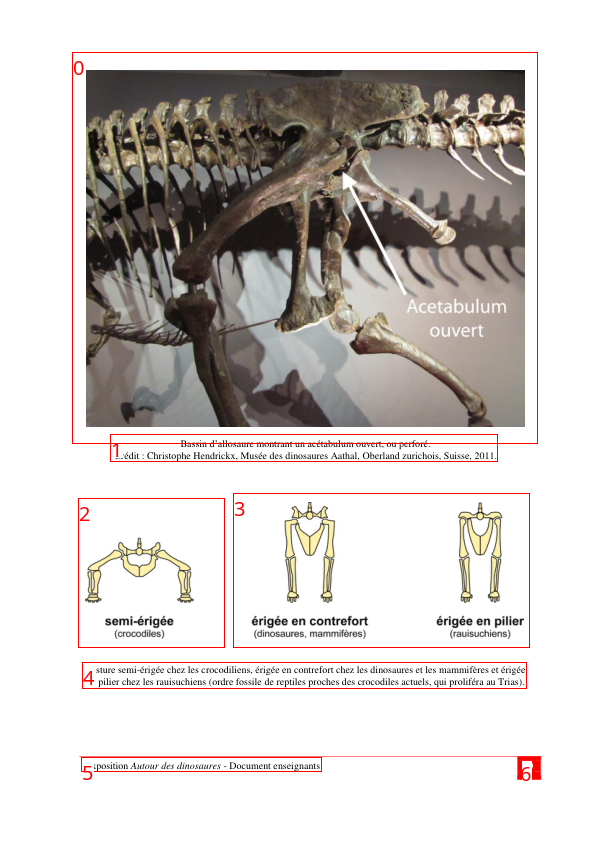

pos      : 4
label    : Text
cur_title: 
cur_subtitle: II.3 Généralités sur les dinosaures
text     : Posture semi-érigée chez les crocodiliens, érigée en contrefort chez les dinosaures et les mammifères et érigée en pilier chez les rauisuchiens (ordre fossile de reptiles proches des crocodiles actuels, qui proliféra au Trias).
len text : 227




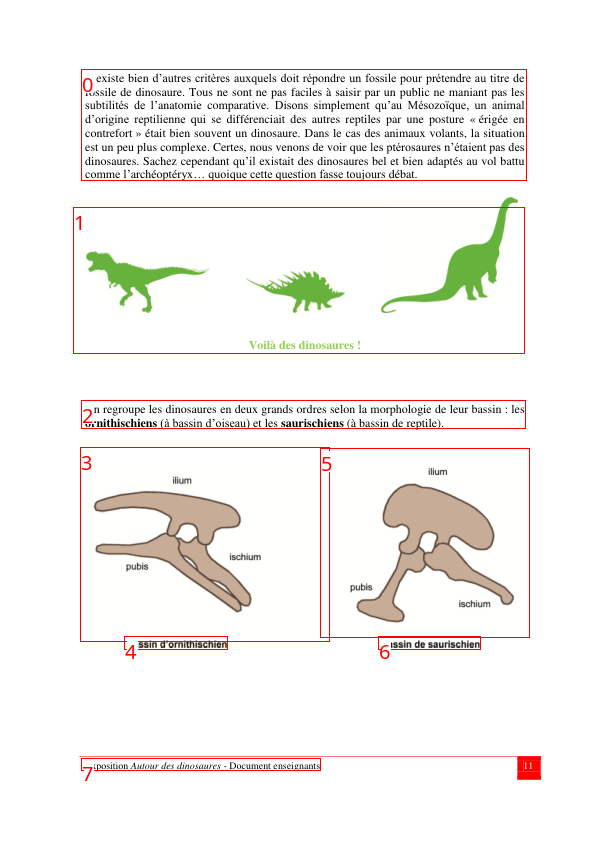

pos      : 0
label    : Text
cur_title: 
cur_subtitle: II.3 Généralités sur les dinosaures
text     : Il existe bien d’autres critères auxquels doit répondre un fossile pour prétendre au titre de fossile de dinosaure. Tous ne sont ne pas faciles à saisir par un public ne maniant pas les subtilités de l’anatomie comparative. Disons simplement qu’au Mésozoïque, un animal d’origine reptilienne qui se différenciait des autres reptiles par une posture « érigée en contrefort » était bien souvent un dinosaure. Dans le cas des animaux volants, la situation est un peu plus complexe. Certes, nous venons de voir que les ptérosaures n’étaient pas des dinosaures. Sachez cependant qu’il existait des dinosaures bel et bien adaptés au vol battu comme l’archéoptéryx… quoique cette question fasse toujours débat.
len text : 703


pos      : 2
label    : Text
cur_title: 
cur_subtitle: II.3 Généralités sur les dinosaures
text     : On regroupe les dinosaures en deux grands ordres selon la morphologie de le

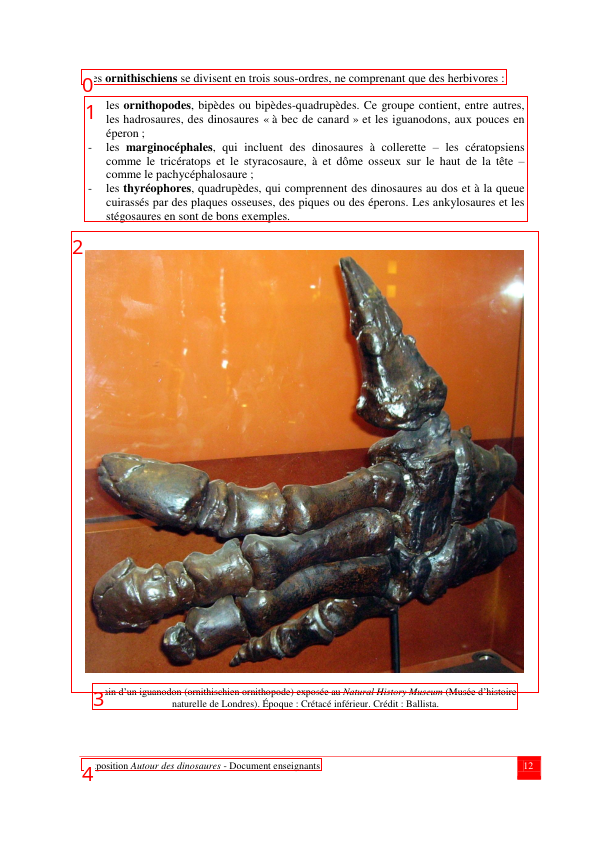

pos      : 1
label    : Text
cur_title: 
cur_subtitle: II.3 Généralités sur les dinosaures
text     : -  les ornithopodes, bipèdes ou bipèdes-quadrupèdes. Ce groupe contient, entre autres, les hadrosaures, des dinosaures « à bec de canard » et les iguanodons, aux pouces en éperon ;
-  les marginocéphales, qui incluent des dinosaures à collerette – les cératopsiens comme le tricératops et le styracosaure, à et dôme osseux sur le haut de la tête – comme le pachycéphalosaure ;
-  les thyréophores, quadrupèdes, qui comprennent des dinosaures au dos et à la queue cuirassés par des plaques osseuses, des piques ou des éperons. Les ankylosaures et les stégosaures en sont de bons exemples.
len text : 587




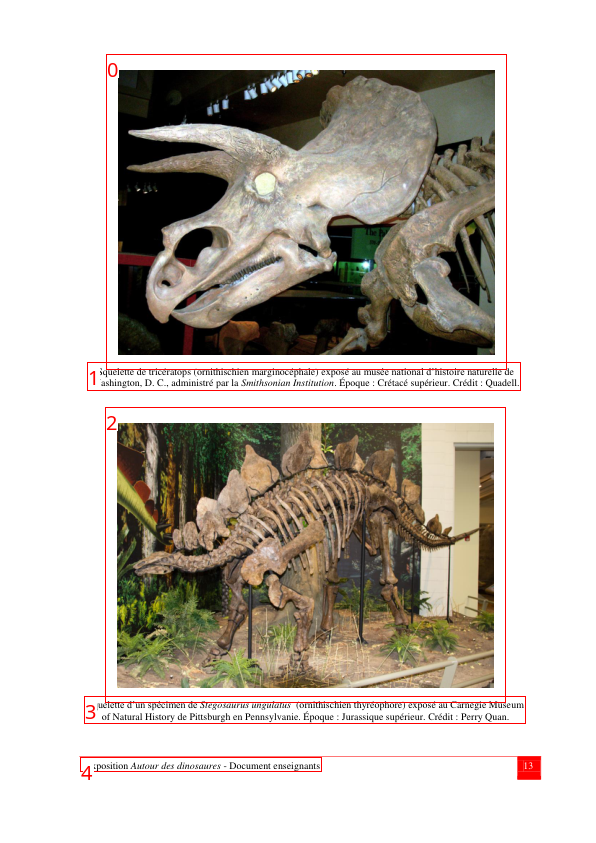

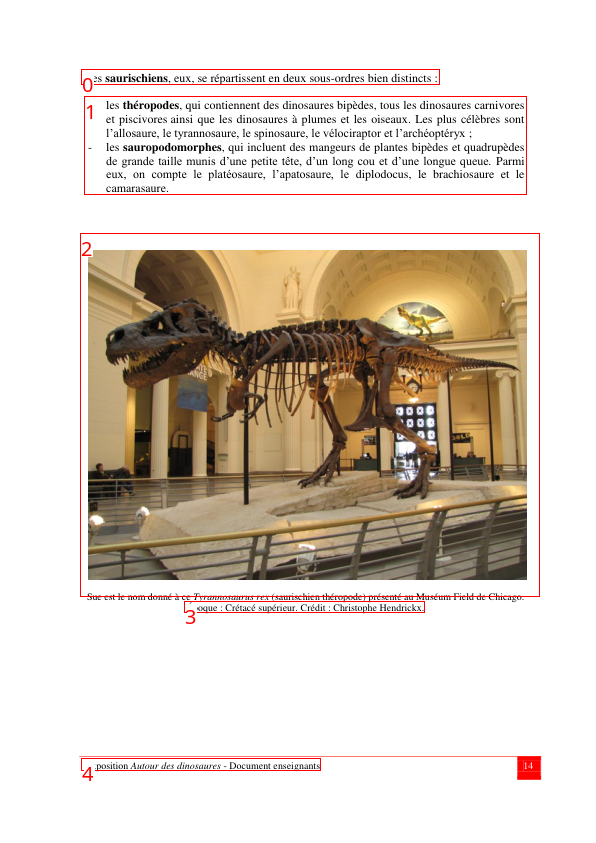

pos      : 1
label    : Text
cur_title: 
cur_subtitle: II.3 Généralités sur les dinosaures
text     : -  les théropodes, qui contiennent des dinosaures bipèdes, tous les dinosaures carnivores et piscivores ainsi que les dinosaures à plumes et les oiseaux. Les plus célèbres sont l’allosaure, le tyrannosaure, le spinosaure, le vélociraptor et l’archéoptéryx ;
-  les sauropodomorphes, qui incluent des mangeurs de plantes bipèdes et quadrupèdes de grande taille munis d’une petite tête, d’un long cou et d’une longue queue. Parmi eux, on compte le platéosaure, l’apatosaure, le diplodocus, le brachiosaure et le camarasaure.
len text : 522




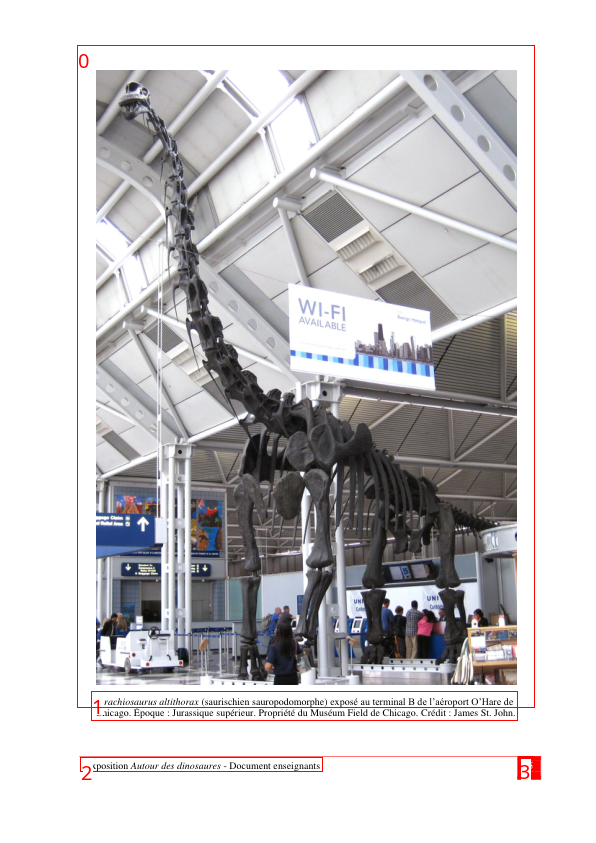

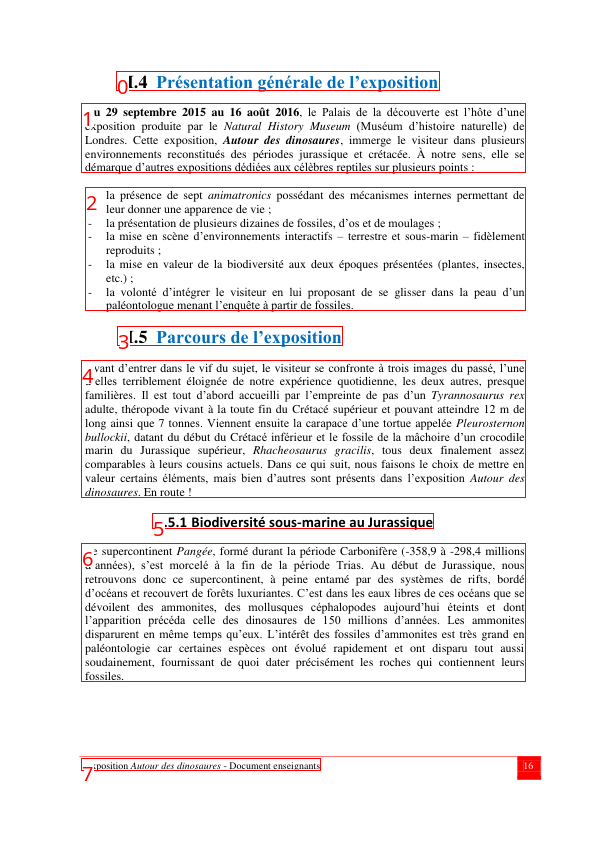

pos      : 1
label    : Text
cur_title: 
cur_subtitle: II.4 Présentation générale de l’exposition
text     : Du 29 septembre 2015 au 16 août 2016, le Palais de la découverte est l’hôte d’une exposition produite par le Natural History Museum (Muséum d’histoire naturelle) de Londres. Cette exposition, Autour des dinosaures, immerge le visiteur dans plusieurs environnements reconstitués des périodes jurassique et crétacée. À notre sens, elle se démarque d’autres expositions dédiées aux célèbres reptiles sur plusieurs points :
len text : 419


pos      : 2
label    : Text
cur_title: 
cur_subtitle: II.4 Présentation générale de l’exposition
text     : -  la présence de sept animatronics possédant des mécanismes internes permettant de leur donner une apparence de vie ;
-  la présentation de plusieurs dizaines de fossiles, d’os et de moulages ;
-  la mise en scène d’environnements interactifs – terrestre et sous-marin – fidèlement reproduits ;
-  la mise en valeur de la biodiversité aux deux 

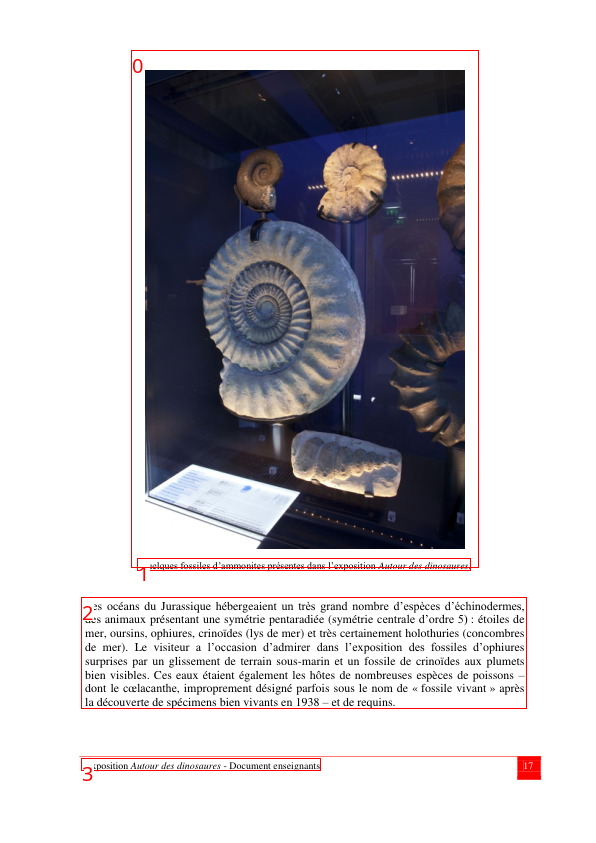

pos      : 2
label    : Text
cur_title: 
cur_subtitle: II.5.1 Biodiversité sous-marine au Jurassique
text     : Les océans du Jurassique hébergeaient un très grand nombre d’espèces d’échinodermes, des animaux présentant une symétrie pentaradiée (symétrie centrale d’ordre 5) : étoiles de mer, oursins, ophiures, crinoïdes (lys de mer) et très certainement holothuries (concombres de mer). Le visiteur a l’occasion d’admirer dans l’exposition des fossiles d’ophiures surprises par un glissement de terrain sous-marin et un fossile de crinoïdes aux plumets bien visibles. Ces eaux étaient également les hôtes de nombreuses espèces de poissons – dont le cœlacanthe, improprement désigné parfois sous le nom de « fossile vivant » après la découverte de spécimens bien vivants en 1938 – et de requins.
len text : 684




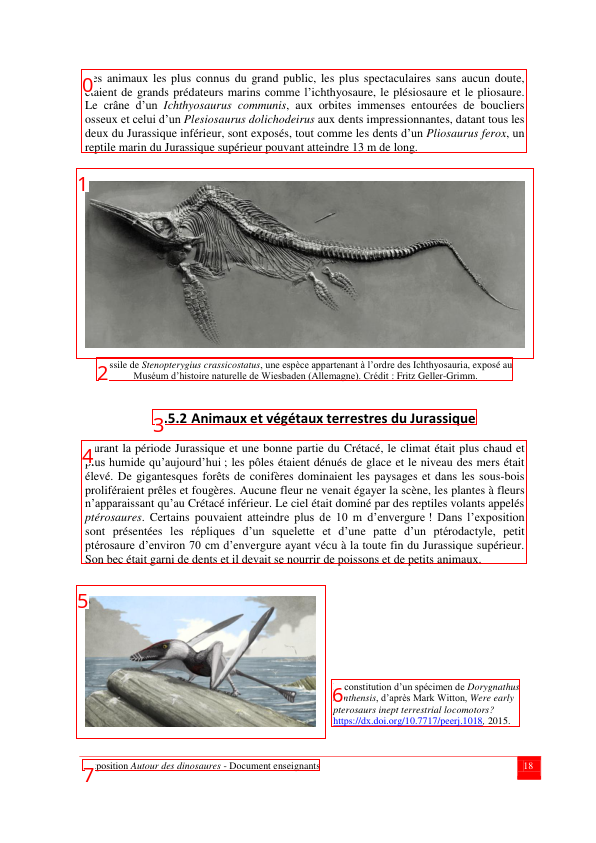

pos      : 0
label    : Text
cur_title: 
cur_subtitle: II.5.1 Biodiversité sous-marine au Jurassique
text     : Les animaux les plus connus du grand public, les plus spectaculaires sans aucun doute, étaient de grands prédateurs marins comme l’ichthyosaure, le plésiosaure et le pliosaure. Le crâne d’un Ichthyosaurus communis, aux orbites immenses entourées de boucliers osseux et celui d’un Plesiosaurus dolichodeirus aux dents impressionnantes, datant tous les deux du Jurassique inférieur, sont exposés, tout comme les dents d’un Pliosaurus ferox, un reptile marin du Jurassique supérieur pouvant atteindre 13 m de long.
len text : 511


pos      : 4
label    : Text
cur_title: 
cur_subtitle: II.5.2 Animaux et végétaux terrestres du Jurassique
text     : Durant la période Jurassique et une bonne partie du Crétacé, le climat était plus chaud et plus humide qu’aujourd’hui ; les pôles étaient dénués de glace et le niveau des mers était élevé. De gigantesques forêts de conifères dominaient les p

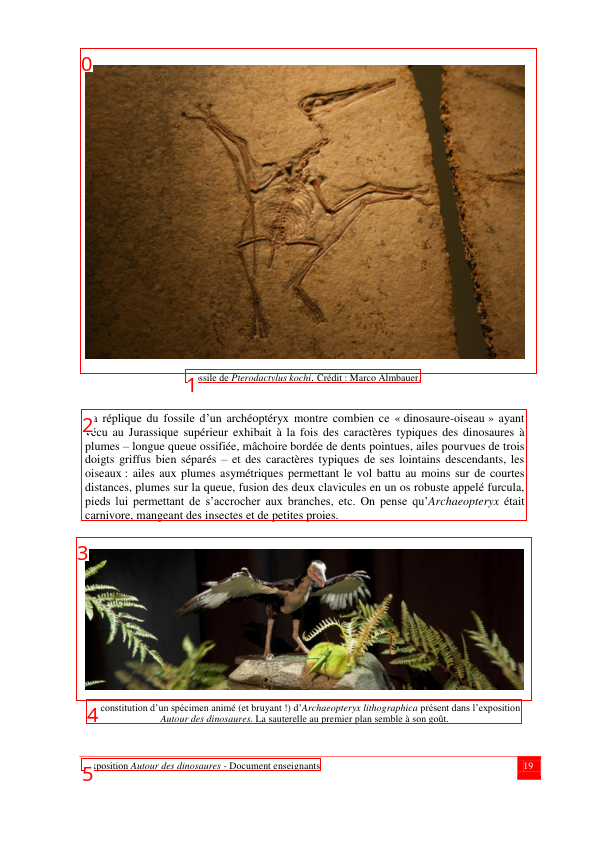

pos      : 2
label    : Text
cur_title: 
cur_subtitle: II.5.2 Animaux et végétaux terrestres du Jurassique
text     : La réplique du fossile d’un archéoptéryx montre combien ce « dinosaure-oiseau » ayant vécu au Jurassique supérieur exhibait à la fois des caractères typiques des dinosaures à plumes – longue queue ossifiée, mâchoire bordée de dents pointues, ailes pourvues de trois doigts griffus bien séparés – et des caractères typiques de ses lointains descendants, les oiseaux : ailes aux plumes asymétriques permettant le vol battu au moins sur de courtes distances, plumes sur la queue, fusion des deux clavicules en un os robuste appelé furcula, pieds lui permettant de s’accrocher aux branches, etc. On pense qu’Archaeopteryx était carnivore, mangeant des insectes et de petites proies.
len text : 678




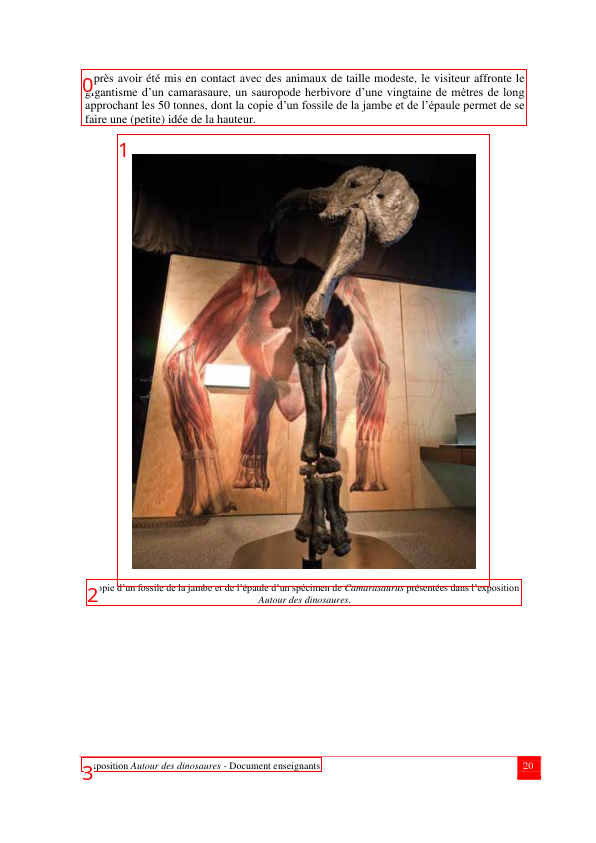

pos      : 0
label    : Text
cur_title: 
cur_subtitle: II.5.2 Animaux et végétaux terrestres du Jurassique
text     : Après avoir été mis en contact avec des animaux de taille modeste, le visiteur affronte le gigantisme d’un camarasaure, un sauropode herbivore d’une vingtaine de mètres de long approchant les 50 tonnes, dont la copie d’un fossile de la jambe et de l’épaule permet de se faire une (petite) idée de la hauteur.
len text : 308




In [37]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import io
import pymupdf as fitz

labels = ["Caption","Footnote","Formula","List-item","Page-footer","Page-header","Picture","Figure","Section-header","Table","Text","Title"]
TITLES = ["Title"]
SUB_TITLES = ["Section-header", "Page-header"]
TEXTS = ["Text", "List-item"]

def restructure_text(text:str):
    """
    Restructures the given text by combining lines that start with '- ' into a single line, and removing leading/trailing whitespace from each line.
    It aims to deal with bullet lists in texts extracted from pdf 
    """
    lines = text.split('\n')
    result = []
    current_line = ''

    for line in lines:
        if line.startswith('- '):
            if current_line:
                result.append(current_line.strip())
            current_line = line
        else:
            current_line += ' ' + line.strip()

    if current_line:
        result.append(current_line.strip())

    return '\n'.join(result)

def keep_text(text:str):
    if (len(text) > 100):
        return True
    return False

# for page_index in range(len(doc)):
current_title = ""
current_subtitle = ""
for page_index in range(100)[6:20]:
    page = doc[page_index]
    preds = result_preds[page_index]
    labels = result_labels[page_index]
    img = result_imgs[page_index]

    display(img)
    # show = False
    # Sort bounding boxes by position
    sorted_indices = sorted(range(len(preds.bboxes)), key=lambda i: preds.bboxes[i].position)
    # Zip and iterate over sorted bounding boxes, labels, and indices
    for i in sorted_indices:
        box = preds.bboxes[i]
        label = labels[i]
        
        
        left, top, right, bottom = box.bbox
        # clean text
        text = restructure_text(page.get_text("text", clip=box.bbox))
        if (label in TITLES):
            current_title = text
        if (label in SUB_TITLES):
            current_subtitle = text

        width = img.width
        page_rect = page.rect
        page_width = page_rect.width
        page_height = page_rect.height
        if (keep_text(text) is True and label in TEXTS):
            show = True
            print("pos      :", box.position)
            print("label    :", label)
            print("cur_title:", current_title)
            print("cur_subtitle:", current_subtitle)
            print("text     :", text)
            print("len text :", len(text))
            print("\n===================\n")
    # if (show):
    #     display(img)


In [33]:
def restructure_text(text):
    lines = text.split('\n')
    result = []
    current_line = ''

    for line in lines:
        if line.startswith('- '):
            if current_line:
                result.append(current_line.strip())
            current_line = line
        else:
            current_line += ' ' + line.strip()

    if current_line:
        result.append(current_line.strip())

    return '\n'.join(result)

print(restructure_text("""- le chien mange des fruits
- le chat est beau
et gentil"""))

- le chien mange des fruits
- le chat est beau et gentil
